### GPU setup

In [1]:
!pip uninstall -y tensorflow
!pip install tensorflow[and-cuda]

Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
  Using cached tensorflow-2.19.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
Using cached tensorflow-2.19.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (645.0 MB)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import tensorflow as tf

2025-07-19 17:44:28.679288: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-19 17:44:28.702424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752965068.729681  137082 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752965068.736349  137082 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752965068.760216  137082 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("Built with CUDA: ", tf.test.is_built_with_cuda())

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA:  True


In [4]:
import subprocess
import sys

# Check NVIDIA driver
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    print("NVIDIA-SMI output:")
    print(result.stdout)
except FileNotFoundError:
    print("nvidia-smi not found. NVIDIA drivers may not be installed.")


NVIDIA-SMI output:
Sat Jul 19 17:44:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.65                 Driver Version: 566.07         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   80C    P3             12W /   35W |    1573MiB /   4096MiB |     32%      Default |
|                                         |                        |                  N/A |
+----------------------------

--- 

## Loading data into tensorflow for training

In [5]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt

In [6]:
images_path = 'raw_data/archive/train'

img_height = 48
img_width = 48

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="training",
    seed=420,
    image_size=(img_height, img_width),
    batch_size=32,
    color_mode='grayscale'
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


I0000 00:00:1752965079.467117  137082 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [7]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="validation",
    seed=420,
    image_size=(img_height, img_width),
    batch_size=32,
    color_mode='grayscale'
)

Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [8]:
train_dataset.class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

#### HEADS UP!
We're going to discard the disgust feeling due to the fact that there is not enough images to be fairly trained against the others sentiments.

2025-07-19 17:44:45.242993: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


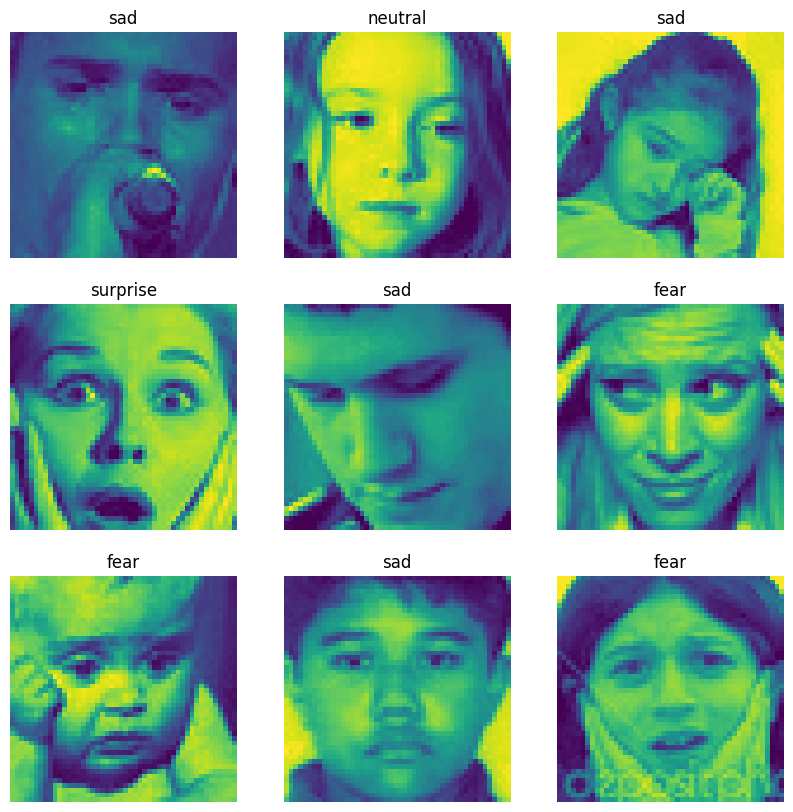

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_dataset.class_names[labels[i]])
        plt.axis("off")

In [10]:
for images, labels in train_dataset.take(1):
    print(images.shape)
    break

(32, 48, 48, 1)


---
## Starting off with the CNN model

In [11]:
# lets remove all the disgust labeled imagess
train_dataset.class_names

def filter_disgust(image, label):
    return tf.reduce_all(tf.not_equal(label, 1)) # 1 is the index for disgust in the class names

train_dataset_filtered = train_dataset.filter(filter_disgust)
validation_dataset_filtered = validation_dataset.filter(filter_disgust)


print('===Filtered datasets===')


remaining_labels = set()
for images, labels in train_dataset_filtered.take(5):
    remaining_labels.update(labels.numpy())


print("\nRemaining classes:")
for label_idx in remaining_labels:
    print(f"Label {label_idx}: {train_dataset.class_names[label_idx]}")

===Filtered datasets===

Remaining classes:
Label 0: angry
Label 2: fear
Label 3: happy
Label 4: neutral
Label 5: sad
Label 6: surprise


2025-07-19 17:44:45.887184: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
remaining_labels = set()
for images, labels in train_dataset_filtered.take(5):
    remaining_labels.update(labels.numpy())

num_classes = len(remaining_labels)
print(f"Number of classes after filtering: {num_classes}")

Number of classes after filtering: 6


In [13]:
# Checking what are the types of the datasets
print("Type of train_dataset_filtered and train_dataset:")
print(type(train_dataset_filtered) == type(train_dataset))
print(type(train_dataset_filtered))
print(type(train_dataset))

Type of train_dataset_filtered and train_dataset:
False
<class 'tensorflow.python.data.ops.filter_op._FilterDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [14]:
for images, labels in train_dataset_filtered:
    conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(img_height, img_width, 1))
    fmaps = conv_layer(images)  

/home/salos/.pyenv/versions/3.12.9/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1752965087.125152  137082 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-19 17:44:56.218348: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


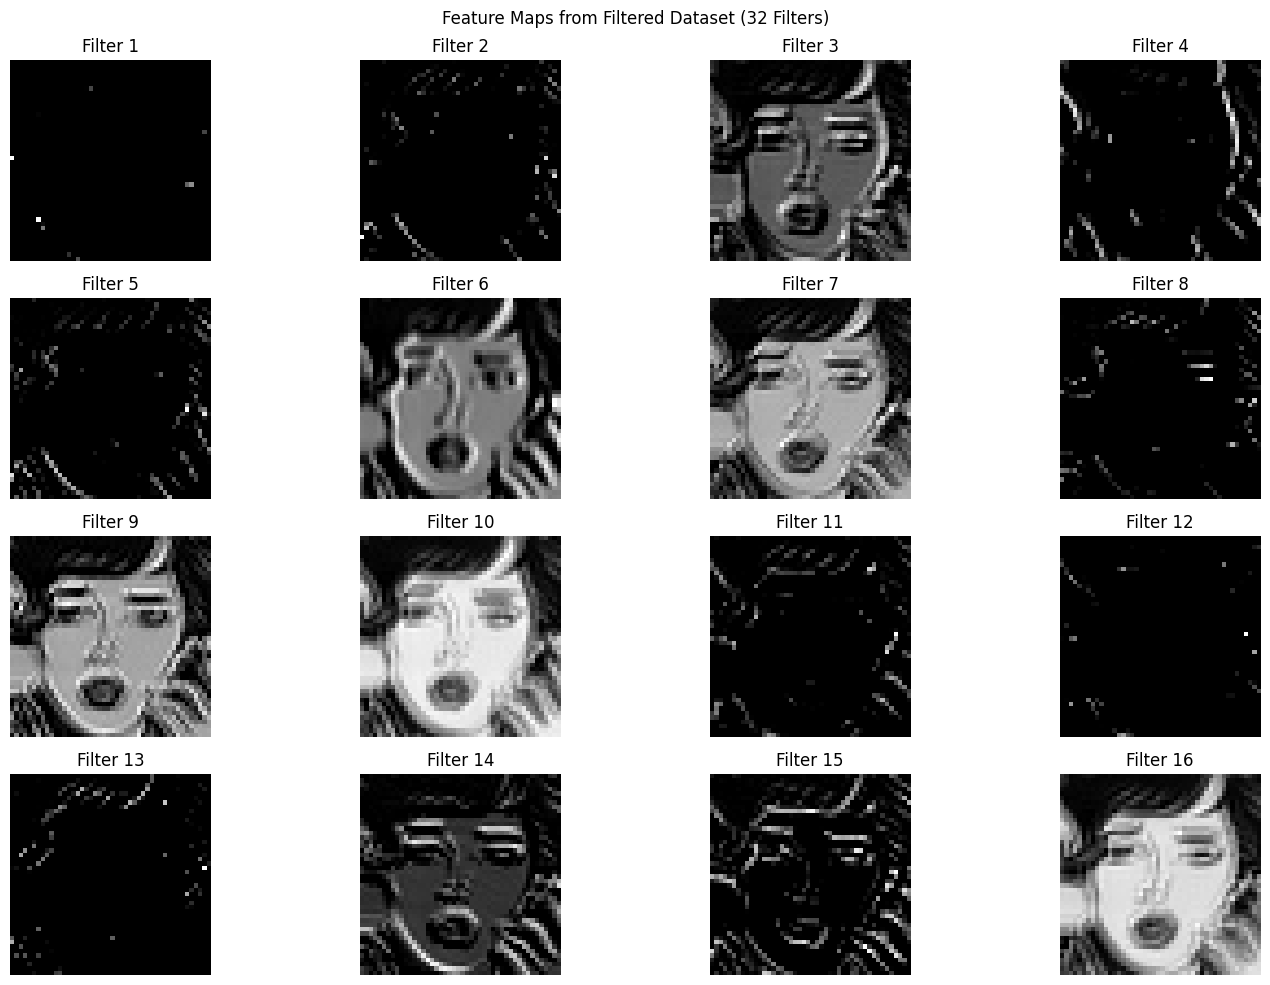

In [15]:
plt.figure(figsize=(15, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fmaps[4, :, :, i], cmap='gray')
    plt.title(f'Filter {i+1}')
    plt.axis('off')
plt.suptitle('Feature Maps from Filtered Dataset (32 Filters)')
plt.tight_layout()
plt.show()

In [109]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')

# Common CNN architecture for grayscale emotion recognition
model = tf.keras.Sequential([
    # tf.keras.layers.Input(shape=(img_height, img_width, 1)),
    DefaultConv2D(filters=32, kernel_size=(7,7), input_shape=(img_height, img_width, 1)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.MaxPooling2D(2, 2),
    DefaultConv2D(filters = 64),
    DefaultConv2D(filters = 64),
    tf.keras.layers.MaxPooling2D(2, 2),
    DefaultConv2D(filters = 128),
    DefaultConv2D(filters = 128),
    tf.keras.layers.MaxPooling2D(2, 2),
    DefaultConv2D(filters = 256),
    DefaultConv2D(filters = 256),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/home/salos/.pyenv/versions/3.12.9/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_570 (Conv2D)             │ (None, 48, 48, 32)     │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_571 (Conv2D)             │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_572 (Conv2D)             │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_573 (Conv2D)             │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_574 (Conv2D)             │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_575 (Conv2D)             │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_576 (Conv2D)             │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,467,398 (5.60 MB)

 Trainable params: 1,467,398 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

In [110]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights to balance training
y_train = []
for images, labels in train_dataset_filtered:
    y_train.extend(labels.numpy())

y_train = np.array(y_train)
unique_classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
class_weight_dict = dict(zip(unique_classes, class_weights))

print(f"\nClass weights: {class_weight_dict}")


Class weights: {np.int32(0): np.float64(1.1700133868808567), np.int32(2): np.float64(1.136910569105691), np.int32(3): np.float64(0.6526649864650425), np.int32(4): np.float64(0.9516809582142371), np.int32(5): np.float64(0.9854827343199436), np.int32(6): np.float64(1.4968957396703062)}


## Training the model

In [111]:
EPOCHS = 10
BATCH_SIZE = 32

history = model.fit(
    train_dataset_filtered,
    validation_data=validation_dataset_filtered,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict 
)

print("Training completed! Lets go!")

Epoch 1/10
    432/Unknown 14s 18ms/step - accuracy: 0.1680 - loss: nan

2025-07-19 19:13:04.023990: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9824513328704784538
2025-07-19 19:13:04.024365: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11405054265435043450
2025-07-19 19:13:04.024396: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12936529601425729364
/home/salos/.pyenv/versions/3.12.9/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


432/432 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.1680 - loss: nan - val_accuracy: 0.1730 - val_loss: nan
Epoch 2/10
  9/432 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.1108 - loss: nan

2025-07-19 19:13:06.131713: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9824513328704784538
2025-07-19 19:13:06.131771: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11405054265435043450


432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.1674 - loss: nan - val_accuracy: 0.1678 - val_loss: nan
Epoch 3/10
  9/432 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.1140 - loss: nan

2025-07-19 19:13:13.138419: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9824513328704784538
2025-07-19 19:13:13.138473: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11405054265435043450


432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.1650 - loss: nan - val_accuracy: 0.1661 - val_loss: nan
Epoch 4/10
  8/432 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1166 - loss: nan

2025-07-19 19:13:20.186508: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9824513328704784538
2025-07-19 19:13:20.186588: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11405054265435043450


432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.1704 - loss: nan - val_accuracy: 0.1744 - val_loss: nan
Epoch 5/10
  9/432 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.1397 - loss: nan

2025-07-19 19:13:27.261834: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9824513328704784538
2025-07-19 19:13:27.261893: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11405054265435043450


432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.1707 - loss: nan - val_accuracy: 0.1808 - val_loss: nan
Epoch 6/10
  8/432 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1026 - loss: nan

2025-07-19 19:13:33.526966: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9824513328704784538
2025-07-19 19:13:33.527025: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11405054265435043450


432/432 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.1689 - loss: nan - val_accuracy: 0.1745 - val_loss: nan
Epoch 7/10
  8/432 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1600 - loss: nan

2025-07-19 19:13:41.238032: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9824513328704784538
2025-07-19 19:13:41.238093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11405054265435043450


432/432 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.1739 - loss: nan - val_accuracy: 0.1718 - val_loss: nan
Epoch 8/10
  8/432 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1214 - loss: nan

2025-07-19 19:13:48.916495: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11405054265435043450


432/432 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.1711 - loss: nan - val_accuracy: 0.1706 - val_loss: nan
Epoch 9/10
  8/432 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1320 - loss: nan

2025-07-19 19:13:56.655013: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9824513328704784538
2025-07-19 19:13:56.655080: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11405054265435043450


432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.1697 - loss: nan - val_accuracy: 0.1724 - val_loss: nan
Epoch 10/10
  8/432 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1521 - loss: nan

2025-07-19 19:14:03.752799: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9824513328704784538
2025-07-19 19:14:03.752866: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11405054265435043450


432/432 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.1686 - loss: nan - val_accuracy: 0.1787 - val_loss: nan
Training completed! Lets go!


2025-07-19 19:14:11.930547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9824513328704784538
2025-07-19 19:14:11.930611: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11405054265435043450


In [112]:
print("=== Model Evaluation ===")

val_loss, val_accuracy = model.evaluate(validation_dataset_filtered, verbose=1)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

print("\n=== Detailed Validation Analysis ===")
y_true = []
y_pred = []

for images, labels in validation_dataset_filtered:
    # print(f" Labels shape: {labels}")
    predictions = model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate accuracy manually
accuracy = np.mean(y_true == y_pred)
print(f"Manual accuracy calculation: {accuracy:.4f}")

# Show classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=[train_dataset.class_names[i] for i in sorted(set(y_true))]))

=== Model Evaluation ===
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1643 - loss: nan

Validation Loss: nan
Validation Accuracy: 0.1670

=== Detailed Validation Analysis ===


2025-07-19 19:14:36.690520: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9824513328704784538
2025-07-19 19:14:36.690566: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11405054265435043450


Manual accuracy calculation: 0.1426

=== Classification Report ===
              precision    recall  f1-score   support

       angry       0.14      1.00      0.25       472
        fear       0.00      0.00      0.00       489
       happy       0.00      0.00      0.00       811
     neutral       0.00      0.00      0.00       584
         sad       0.00      0.00      0.00       573
    surprise       0.00      0.00      0.00       380

    accuracy                           0.14      3309
   macro avg       0.02      0.17      0.04      3309
weighted avg       0.02      0.14      0.04      3309



/home/salos/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/salos/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/salos/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

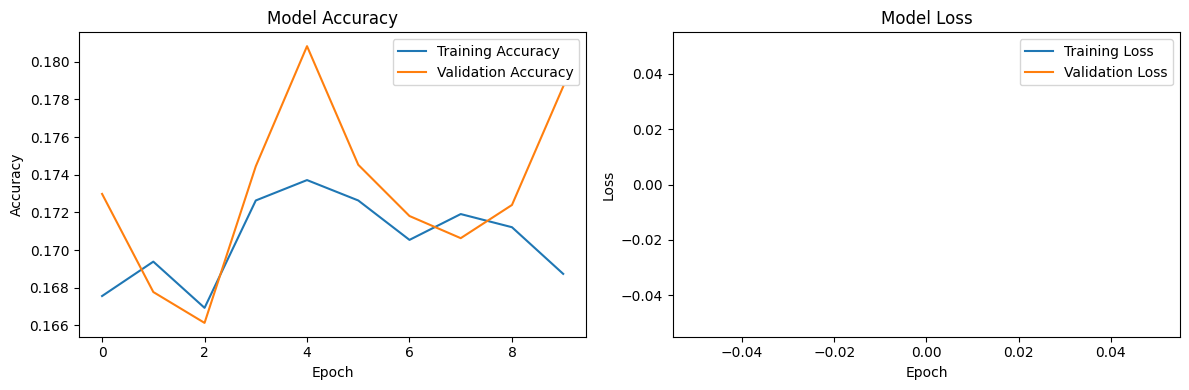

In [113]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

=== Testing Individual Predictions ===


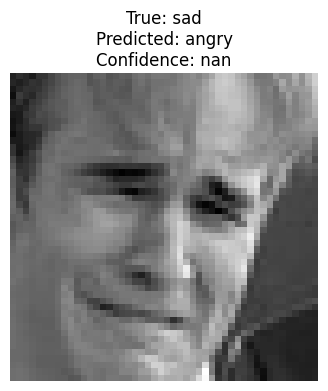

Image 1: True=5, Predicted=0, Correct=False


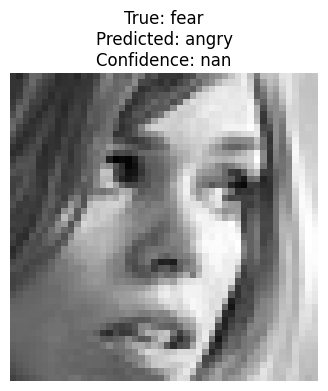

Image 2: True=2, Predicted=0, Correct=False


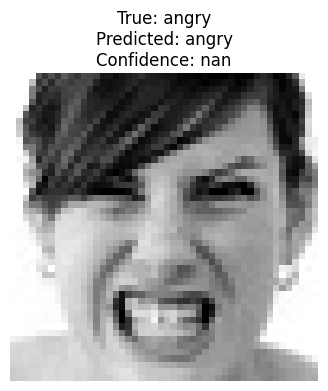

Image 3: True=0, Predicted=0, Correct=True


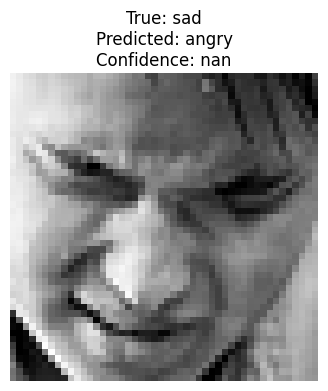

Image 4: True=5, Predicted=0, Correct=False


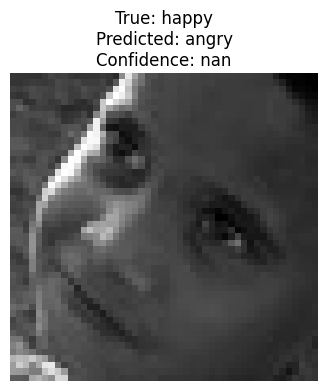

Image 5: True=3, Predicted=0, Correct=False


In [117]:
print("=== Testing Individual Predictions ===")

for images, labels in validation_dataset_filtered.take(1):
    # Test first 5 images in the batch
    for i in range(min(5, len(images))):
        single_image = images[i:i+1]
        true_label = labels[i].numpy()
        
        prediction = model.predict(single_image, verbose=0)
        predicted_class = np.argmax(prediction[0])
        confidence = np.max(prediction[0])
        
        plt.figure(figsize=(6, 4))
        plt.imshow(single_image[0, :, :, 0], cmap='gray')
        plt.title(f"True: {train_dataset.class_names[true_label]}\n"
                 f"Predicted: {train_dataset.class_names[predicted_class]}\n"
                 f"Confidence: {confidence:.3f}")
        plt.axis('off')
        plt.show()
        
        print(f"Image {i+1}: True={true_label}, Predicted={predicted_class}, Correct={true_label==predicted_class}")
    break

In [23]:
# maxpooling layer
maxpool_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))

# Apply maxpooling to the feature maps


In [24]:
for images, labels in train_dataset_filtered.take(1):
    print(images.shape)
    break

(32, 48, 48, 1)
